<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Blob analytical scaling law based on tracking (Script 6_0)</b></span><br>
<span style="font-size: 16px;">
- In this script, we apply the analytical scaling laws derived in the past litteratures. <br>
- There are two existing models for this:<br>
- (1) One makes use of Lambda and Theta<br>
- (2) The other makes use of hat-a and hat-v. 
</span>
</div>



In [3]:
import sys
sys.path.append('/marconi/home/userexternal/klim0000/my_venv/lib/python3.9/site-packages')
#from skimage.measure import label, regionprops

In [4]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors

from skimage import measure

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
from gbspy.blobs import *

In [48]:
#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

# Get the current working directory|
cwd = os.getcwd()

# PT
os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DPT_d0p6')

#NT
#os.chdir('/marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

Current working directory: /marconi_scratch/userexternal/klim0000/GBS/DN_tria/delta_scan/DNT_dn0p6


In [49]:
t2= s.time[-1]
t1= t2 -1

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]


dens         = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg     = np.mean(dens, axis=(2,3)); 
dens_avg_tor = np.mean(dens, axis=2)
dens_std     = np.std(dens, axis=(2,3))

Te  = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
Te_avg  = np.mean(Te, axis=(2,3)); 
Te_avg_tor = np.mean(Te, axis=2)

pe = dens * Te
pe_avg = np.mean(pe, axis=(2,3))
pe_std = np.std(pe, axis=(2,3))

Ti  = s.get_field('Ti', z1=z1, z2=z2, t1=t1, t2=t2)
Ti_avg  = np.mean(Ti, axis=(2,3)); 
Ti_avg_tor = np.mean(Ti, axis=2)

# Normalized
dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
#dens_fluct = dens[:,:,0,-1] - dens_avg
dens_fluct_avg = np.mean(dens_fluct, axis=2)

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Define the mask in the SOL region </b></span><br>
</div>

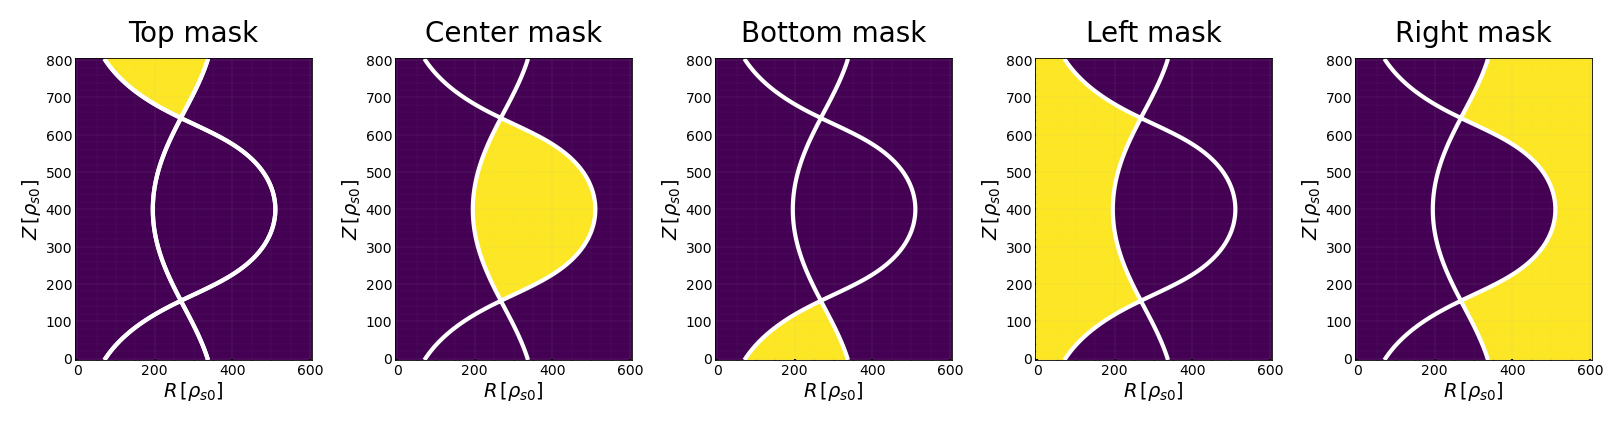

In [53]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=5,  figsize=(8, 2),  dpi=200, constrained_layout=True)

mask_contour=axes[0].contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

mask_bottom = mask_contour.collections[0].get_paths()[0]
mask_top    = mask_contour.collections[0].get_paths()[1]
mask_center = mask_contour.collections[0].get_paths()[2]

# Create a mask for points inside the contour path
inside_mask_bottom = mask_bottom.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
inside_mask_top    = mask_top.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
inside_mask_center = mask_center.contains_points(np.column_stack([X.ravel(), Y.ravel()]))

inside_mask_top    = inside_mask_top.reshape(X.shape)
inside_mask_center = inside_mask_center.reshape(X.shape)
inside_mask_bottom = inside_mask_bottom.reshape(X.shape)

# For left and right part
outside_mask = ~inside_mask_center & ~inside_mask_top & ~inside_mask_bottom

# Get the X coordinates that are to the left of the center region
left_outside_mask = outside_mask & (X < s.x[s.ixxpt])
right_outside_mask = outside_mask & (X > s.x[s.ixxpt])

# Reshape this mask to the original shape if necessary
left_outside_mask = left_outside_mask.reshape(X.shape)
right_outside_mask = right_outside_mask.reshape(X.shape)


# Plot the figure
cs1 = axes[0].pcolormesh(X, Y, inside_mask_top, cmap='viridis')
cs2 = axes[1].pcolormesh(X, Y, inside_mask_center, cmap='viridis')
cs3 = axes[2].pcolormesh(X, Y, inside_mask_bottom, cmap='viridis')
cs4 = axes[3].pcolormesh(X, Y, left_outside_mask, cmap='viridis')
cs5 = axes[4].pcolormesh(X, Y, right_outside_mask, cmap='viridis')

for ax in axes:
    ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='w')

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

for ax in axes:
    ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
    ax.grid(True, which='minor', alpha=0.4, linestyle=':', linewidth=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=5, pad=1)
    ax.tick_params(axis='y', labelsize=5, pad=1)
    ax.tick_params(which='minor', direction="in", size=0.2)
    ax.tick_params(which='major', direction="in", size=0.5)
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=7, labelpad=1)
    ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=7, rotation=90, labelpad=1)
    #ax.legend(bbox_to_anchor=(0.35, 1), loc='upper right', edgecolor='white', prop={'size': 2}, facecolor='white' )
    
axes[0].set_title('Top mask', fontsize=10)
axes[1].set_title('Center mask', fontsize=10)
axes[2].set_title('Bottom mask', fontsize=10)
axes[3].set_title('Left mask', fontsize=10)
axes[4].set_title('Right mask', fontsize=10)

#plt.gca().set_aspect('equal')
plt.show(block=False)

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b> Detect blobs without mask </b></span><br>
</div>

In [59]:
import skimage
from skimage.measure import label, regionprops, find_contours

# Define time range for analysis
time_interval = 0.1
time_steps = dens.shape[-1]
# Structure to hold blob data over time
areas_NT = []; perimeters_NT = []; sizes_NT=[]; Nb_blobs_NT=[]

dens_fluct_avg_NT=[]
for i in range(time_steps):
    dens_fluct_NT   = np.sqrt((dens[:,:,0,i]-dens_avg_tor[:,:,i])**2) / dens_avg_tor[:,:,i]
    dens_fluct_avg_NT.append(dens_fluct_NT)
    #print(np.shape(dens_fluct_NT))

Xb_coordinates = [[] for _ in range(time_steps)]
Yb_coordinates = [[] for _ in range(time_steps)]

# Variables to store properties for the current time step
areas      = [[] for _ in range(time_steps)]
perimeters = [[] for _ in range(time_steps)]
sizes      = [[] for _ in range(time_steps)]
Nb_blobs   = [[] for _ in range(time_steps)]
Nb_blobs_count=0

for t in range(time_steps):    
    # Threshold based on fluctuation
    cst=2.5
    threshold = 0.3 * np.max(dens_fluct_avg_NT[t])
    #binary_image = dens_fluct_avg_NT[t] > dens_avg threshold
    
    binary_image = dens[:,:,0,t] > dens_avg + threshold*dens_std

    # Label the regions in the binary image
    labeled_image = label(binary_image)

    # Calculate properties for each labeled region
    for region in regionprops(labeled_image):
        
        Nb_blobs_count += 1
        areas[t].append(region.area)
        perimeters[t].append(region.perimeter)
        sizes[t].append(region.major_axis_length * region.minor_axis_length)
        Nb_blobs[t].append(Nb_blobs_count)
        
        # X,Y coordinates of the blobs
        Y0, X0 = region.centroid
        Xb_coordinates[t].append(cst*X0)
        Yb_coordinates[t].append(cst*Y0)

### Indices for blobs X, Y coordinates and corresponding density and temperature values

In [51]:
Xb_indices = [[] for _ in range(time_steps)]
Yb_indices = [[] for _ in range(time_steps)]
for t in range(time_steps):
    for Xb in Xb_coordinates[t]:
        index = np.argmin(np.abs(s.x - Xb))
        Xb_indices[t].append(index)
    for Yb in Yb_coordinates[t]:
        index = np.argmin(np.abs(s.y - Yb))
        Yb_indices[t].append(index)
    
    
dens_blobs = [[] for _ in range(time_steps)]
Te_blobs   = [[] for _ in range(time_steps)]
Ti_blobs   = [[] for _ in range(time_steps)]

n0_blobs   = [[] for _ in range(time_steps)]
rhos_blobs = [[] for _ in range(time_steps)]

for t in range(time_steps):
    dens_blobs[t] = [dens[Yb_indices[t][i], Xb_indices[t][i], 0, t] for i in range(len(Xb_indices[t]))]
    Te_blobs[t]   = [Te[Yb_indices[t][i], Xb_indices[t][i], 0, t] for i in range(len(Xb_indices[t]))]
    Ti_blobs[t]   = [Ti[Yb_indices[t][i], Xb_indices[t][i], 0, t] for i in range(len(Xb_indices[t]))]
    
for t in range(time_steps):
    n0_blobs[t] = np.amin(dens_blobs[t])
    rhos_blobs[t] = np.sqrt(np.mean(Te_blobs[t])) 

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b> Blobs without mask </b></span><br>
</div>

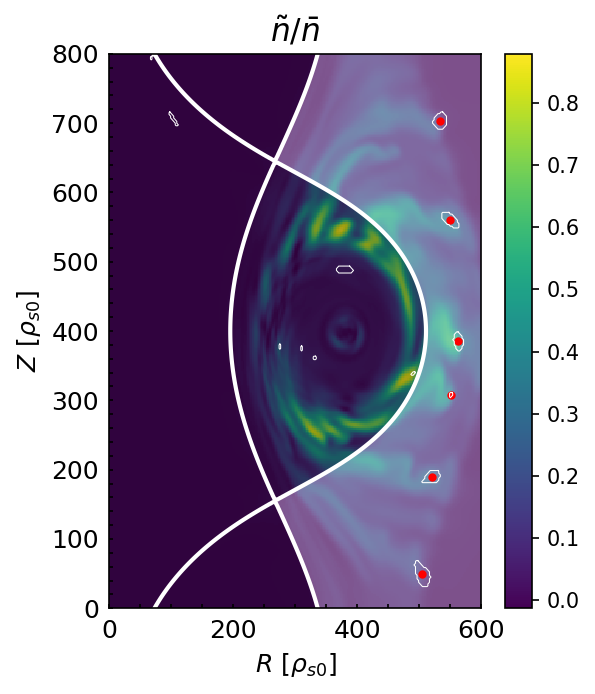

In [58]:
from skimage import measure
from skimage.measure import label, regionprops, find_contours

X,Y = np.meshgrid(s.x, s.y)
    
# Visualize each contour on the original plot
fig, ax = plt.subplots(figsize=(4, 4.8), dpi=150)

cst=2.5

#######################################################
#Choose a threshold level (20 or 30% fluctuation)
#threshold = 0.3* np.max(dens_fluct_avg)
#binary_image = dens_fluct_avg > threshold
threshold = 2.5
binary_image = dens[:,:,0,-1] > dens_avg + threshold*dens_std
##########################################

# Label the regions in the binary image
labeled_image = label(binary_image)

# Find contours using the skimage measure module
contours = measure.find_contours(binary_image.astype(float), 0.5)  # Use 0.5 since binary image is either 0 or 1


areas = []
perimeters = []

Xb_coordinates = []
Yb_coordinates = []
# Calculate properties of each region
for region in regionprops(labeled_image):
    # The area of the region in pixels
    area = region.area
    areas.append(area)

    # The centroid coordinates of the region
    centroid = region.centroid

    # The perimeter of the region in pixels
    perimeter = region.perimeter

    
for region in regionprops(labeled_image):
    
    Nb_blobs_count=0

    
    Y0, X0 = region.centroid
    
    # Convert centroid coordinates to indices
    X0_idx, Y0_idx = int(X0), int(Y0)
    
    # Check if the centroid is within the right side region
    if right_outside_mask[Y0_idx, X0_idx]:
        Nb_blobs_count += 1
        ax.plot(cst*X0, cst*Y0, 'ro', markersize=3)  #

    # X,Y coordinates of the blobs
    Xb_coordinates.append(cst*X0)
    Yb_coordinates.append(cst*Y0)
    
    # The length of the minor and major axis
    minor_axis_length = region.minor_axis_length
    major_axis_length = region.major_axis_length

    # The orientation of the ellipse
    orientation = region.orientation

    # Get the end points of the major axis
    X_major_axis_end1 = X0 + np.cos(orientation) * 0.5 * major_axis_length
    Y_major_axis_end1 = Y0 - np.sin(orientation) * 0.5 * major_axis_length
    X_major_axis_end2 = X0 - np.cos(orientation) * 0.5 * major_axis_length
    Y_major_axis_end2 = Y0 + np.sin(orientation) * 0.5 * major_axis_length

    # Get the end points of the minor axis
    X_minor_axis_end1 = X0 + np.sin(orientation) * 0.5 * minor_axis_length
    Y_minor_axis_end1 = Y0 + np.cos(orientation) * 0.5 * minor_axis_length
    X_minor_axis_end2 = X0 - np.sin(orientation) * 0.5 * minor_axis_length
    Y_minor_axis_end2 = Y0 - np.cos(orientation) * 0.5 * minor_axis_length

    # Plot the major axis
    #ax.plot([cst*X_major_axis_end1, cst*X_major_axis_end2],
    #        [cst*Y_major_axis_end1, cst*Y_major_axis_end2], 'b-')

    # Plot the minor axis
    #ax.plot([cst*X_minor_axis_end1, cst*X_minor_axis_end2],
    #        [cst*Y_minor_axis_end1, cst*Y_minor_axis_end2], 'b-')
    

# Size measurements
for region in regionprops(labeled_image):
    size_major = region.major_axis_length
    size_minor = region.minor_axis_length
    
    # The size can be considered as the product of the major and minor lengths (for an ellipse)
    # But, I will just calculate the area of contour...
    size = size_major * size_minor

    
#cs = ax.pcolormesh(X, Y, dens_fluct_avg, cmap='viridis') #RdBu, viridis
#cs = ax.pcolormesh(X, Y, dens[:,:,0,-1]-(dens_avg), cmap='viridis') #RdBu, viridis
cs = ax.pcolormesh(X, Y, dens[:,:,0,-1]-dens_avg + threshold*dens_std, cmap='viridis') #RdBu, viridis
cs5 = ax.pcolormesh(X, Y, right_outside_mask, cmap='binary_r', alpha=0.3)

#binary_image = dens[:,:,0,t] > dens_avg + threshold*dens_std
cbar = fig.colorbar(cs)
#cs5 = ax.pcolormesh(X, Y, right_outside_mask, cmap='binary_r', alpha=0.5)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w', linewidths=2)

for contour in contours:
    ax.plot(cst*contour[:, 1], cst*contour[:, 0], linewidth=0.5, c='w')  # No need to adjust contour plotting orientation

# Set the axes labels
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=12, width=0.8, size=2, pad=5)
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=12)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=12, rotation=90)
ax.set_title(r'$\tilde{n}/\bar{n}$', fontsize=15)
ax.set_xlim([0,600]); ax.set_ylim([0,800])

plt.show()

<div class="alert alert-block alert-info">
    <span style="font-size: 26px;"><b>Ex </b></span><br>
</div>

In [104]:
Xpsi, Ypsi, rpsi, chi, dchi = build_grid(s, 0.95, 0.99, Nchi=200)

<div class="alert alert-block alert-info">
    <span style="font-size: 26px;"><b>Blob velocities </b></span><br>
</div>

In [11]:
dens_fluct_avg = []
t2= s.time[-1]
t1= t2 -1
dens  = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
for i in range(dens.shape[-1]):
    density = dens[:,:,:,i]
    dens_avg = np.mean(density, axis=2)
    dens_fluct = np.sqrt((density[:,:,0] - dens_avg)**2) / dens_avg
    dens_fluct_avg.append(dens_fluct)

# Convert list of arrays to a single 3D NumPy array
dens_fluct_avg_array = np.stack(dens_fluct_avg, axis=-1)
np.shape(dens_fluct_avg_array)

(324, 244, 11)

In [12]:
import numpy as np
from skimage import measure
from scipy.spatial.distance import cdist


centroids_over_time = []

time_interval = 1  # Replace with your actual time step

for t in range(0, dens_fluct_avg_array.shape[-1], 3):
    dens_fluct_avg = dens_fluct_avg_array[:, :, t]

    # Apply the mask to the density fluctuations
    masked_dens_fluct = np.where(right_outside_mask, dens_fluct_avg, np.nan)

    threshold = 0.3 * np.nanmax(masked_dens_fluct)
    binary_image = masked_dens_fluct > threshold
    labeled_image = measure.label(binary_image)

    # Extract centroids for this time step within the masked region
    centroids = [region.centroid for region in measure.regionprops(labeled_image) if right_outside_mask[int(region.centroid[0]), int(region.centroid[1])]]
    centroids_over_time.append(centroids)

# Now calculate the velocities based on centroids
velocities = []

for t in range(len(centroids_over_time) - 1):
    current_centroids = centroids_over_time[t]
    next_centroids = centroids_over_time[t + 1]

    # Calculate the distance between centroids
    distances = cdist(current_centroids, next_centroids)

    # Find the closest centroids between frames (assuming minimal movement)
    for i, centroid in enumerate(current_centroids):
        closest_index = np.argmin(distances[i])
        closest_centroid = next_centroids[closest_index]

        # Calculate the displacement
        displacement = np.linalg.norm(np.array(centroid) - np.array(closest_centroid))

        # Calculate the velocity and append to the list
        velocity = displacement / time_interval
        velocities.append(velocity)

# Now calculate the x-component of velocities based on centroids
x_velocities = []

# Loop over the centroids list (except the last one)
for t in range(len(centroids_over_time) - 1):
    current_centroids = centroids_over_time[t]
    next_centroids = centroids_over_time[t + 1]

    # If no centroids in either list, skip to next iteration
    if not current_centroids or not next_centroids:
        continue

    # Calculate the pairwise distance between centroids
    distances = cdist(current_centroids, next_centroids)

    # Track x-velocity for matched centroids
    for i, centroid in enumerate(current_centroids):
        if len(next_centroids) > i:  # Ensure there is a centroid to compare to
            # Find the closest centroid in the next frame
            closest_index = np.argmin(distances[i])

            # Calculate the x-component of displacement
            x_displacement = next_centroids[closest_index][1] - centroid[1]

            # Calculate the x-component of the velocity
            x_velocity = x_displacement / time_interval
            x_velocities.append(x_velocity)

# x_velocities contains the x-component of the velocity of each matched blob between consecutive frames

# Filter the list to include only positive x-velocities
positive_x_velocities = [velocity for velocity in x_velocities if velocity > 0]

# Now positive_x_velocities contains only the positive x-components of the velocity


NameError: name 'right_outside_mask' is not defined

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Exercises </b></span><br>
</div>

In [ ]:
nu = s.attribute['nu']
R = s.attribute['rorho_s']
tau = s.attribute['tau']

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Functions </b></span><br>
</div>

# Function 'Build_grid'

In [100]:
#Xpsi, Ypsi, rpsi, chi, dchi = build_grid(s, 0.7, 0.8, Nchi=200)
from gbspy.utils import intersection
from scipy.interpolate import RectBivariateSpline


rmin=0.9; rmax=0.91; Nchi=200
def build_grid(s, rmin, rmax, Nchi=200):
    X, Y = np.meshgrid(s.x, s.y)
    Xcoord = {}
    Ycoord = {}
    rpsi = []

    if(rmax <= 1): 
        ix_min = s.find_ind(s.x0 + rmin*s.rminor, s.x)
        ix_max = s.find_ind(s.x0 + rmax*s.rminor, s.x)
        iy0 = s.find_ind(s.y0, s.y)
        ix = np.arange(ix_min, ix_max, 1)
        Nr = ix.shape[0]
        plt.figure(dpi=50)
        for i in ix: 
            cs = plt.contour(X, Y, s.Psi, levels=[s.Psi[iy0, i]])
            #p0  =cs.collections[0].get_paths()[0] # Lower
            #p1  =cs.collections[0].get_paths()[1] # Upper
            #p2  = cs.collections[0].get_paths()[2] # Center
            p = cs.collections[0].get_paths()[2]
            v = p.vertices
            Xcoord[i] = v[:, 0]
            Ycoord[i] = v[:, 1]
            rtmp, _ = intersection(np.array([s.x0, s.xmax]),
                                   np.array([s.y0, s.y0]),
                                   Xcoord[i], Ycoord[i])
            rpsi.append((rtmp[0] - s.x0)/s.rminor)
        plt.close()
        alpha = [-2*np.pi*i/Nchi for i in range(0, Nchi)]
        rtmp = np.array([1, 2*s.rminor])
        Xint = []
        Yint = []
        for al in alpha:
            xtmp = rtmp * np.cos(al) + s.x0
            ytmp = rtmp * np.sin(al) + s.y0
            xx, yy = intersection(Xcoord[ix[0]], Ycoord[ix[0]], xtmp, ytmp)
            Xint.append(xx[0])
            Yint.append(yy[0])


    if(rmin >= 1):
        if(rmin == 1):
            ix_min = s.find_ind(s.x0 + s.rminor, s.x) + 1
        else:
            ix_min = s.find_ind(s.x0 + rmin * s.rminor, s.x)
        ix_max = s.find_ind(rmax*s.rminor + s.x0, s.x)
        iy0 = s.find_ind(s.y0, s.y)
        ix_min = s.find_ind(s.Psi[iy0, ix_min],
                            s.Psi[s.iyxpt, s.ixxpt:]) + s.ixxpt
        ix_max = s.find_ind(s.Psi[iy0, ix_max],
                            s.Psi[s.iyxpt, s.ixxpt:]) + s.ixxpt

        if(rmin == rmax):
            ix_min = ix_max
        ix = np.arange(ix_min, ix_max, 1)
        Nr = ix.shape[0]
        rpsi = []
        plt.figure(dpi=50)
        for ind, i in enumerate(ix):
            cs = plt.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, i]])
            p = cs.collections[0].get_paths()[0]
            v = p.vertices
            rtmp, _ = intersection(np.array([s.x0, s.xmax]),
                                   np.array([s.y0, s.y0]),
                                   v[:, 0], v[:, 1])

            try:
                rpsi.append((rtmp[0] - s.x0)/s.rminor)
            except IndexError:
                print('rmax set to ', rpsi[-1])
                Nr = len(ix[:ind])
                break

            Xcoord[i] = v[:, 0]
            Ycoord[i] = v[:, 1]

        plt.close()
        Xint = []
        Yint = []
        Xint.append(Xcoord[ix[0]][0])
        Yint.append(Ycoord[ix[0]][0])
        alpha = np.linspace(0, 2*np.pi, 100)
        rcirc = np.sqrt(s.dx**2 + s.dy**2)*2
        i = 0
        while 1:
            if (np.abs(Yint[i] - Ycoord[ix[0]][-1]) <= rcirc and np.abs(
                    Xint[i] - Xcoord[ix[0]][-1]) <= rcirc and i > 1):
                break
            xtmp = Xint[i] + rcirc*np.cos(alpha)
            ytmp = Yint[i] + rcirc*np.sin(alpha)
            xx, yy = intersection(Xcoord[ix[0]],
                                  Ycoord[ix[0]],
                                  xtmp,
                                  ytmp)
            if ((i > 0) and np.abs(
                    Xint[i-1] - xx[0]) < rcirc and np.abs(
                        Yint[i-1] - yy[0]) < rcirc):
                Xint.append(xx[1])
                Yint.append(yy[1])
            else:
                Xint.append(xx[0])
                Yint.append(yy[0])
            i = i + 1

    try:
        dpsidx = s.dpsidx_v
        dpsidy = s.dpsidy_v
    except AttributeError:
        dpsidx = np.zeros(s.Psi.shape)
        dpsidy = np.zeros(s.Psi.shape)
        dpsidx[:, 1:] = np.diff(s.Psi, 1, axis=1)/s.dx
        dpsidy[1:, :] = np.diff(s.Psi, 1, axis=0)/s.dy

    dpsidx_int = RectBivariateSpline(s.y, s.x, dpsidx)
    dpsidy_int = RectBivariateSpline(s.y, s.x, dpsidy)

    if(rmin >= 1):
        Ns = 4
        Np = len(Xint) - 4
    else:
        Ns = 0
        Np = len(Xint)
    Nt = Np - Ns

    Xpsi = np.empty([Nr, Nt])
    Ypsi = np.empty([Nr, Nt])
    Xpsi[0, :] = Xint[Ns:Np]
    Ypsi[0, :] = Yint[Ns:Np]
    chi = np.zeros([Nr, Nt])
    dchi = np.zeros([Nr, Nt])
    for j in range(1, Nt):
        dchi[0, j] = np.sqrt((Xint[j-1] - Xint[j])**2 +
                             (Yint[j-1] - Yint[j])**2)
        chi[0, j] = chi[0, j-1] + dchi[0, j]
    chi[0, :] = chi[0, :]/chi[0, -1]

    for ind, ir in enumerate(list(Xcoord.keys())):
        if ind == 0:
            continue
        for ic in range(Ns, Np):
            normx = dpsidx_int(Yint[ic], Xint[ic])/np.sqrt(
                dpsidx_int(Yint[ic], Xint[ic])**2 +
                dpsidy_int(Yint[ic], Xint[ic])**2)
            normy = dpsidy_int(Yint[ic], Xint[ic])/np.sqrt(
                dpsidx_int(Yint[ic], Xint[ic])**2 +
                dpsidy_int(Yint[ic], Xint[ic])**2)
            xtmp = Xint[ic] + normx*np.arange(-20, 20, 1)
            ytmp = Yint[ic] + normy*np.arange(-20, 20, 1)
            xx, yy = intersection(Xcoord[ir], Ycoord[ir],
                                  np.transpose(xtmp), np.transpose(ytmp))

            if (ic == Ns):
                if(len(xx) > 1):
                    xx = xx[0]
                    yy = yy[0]
                if xx:
                    Xint[ic] = xx[0]
                    Yint[ic] = yy[0]
                else:
                    Xint[ic] = Xcoord[ir][0]
                    Yint[ic] = Ycoord[ir][0]
            elif(ic == Np):
                if xx:
                    Xint[ic] = xx[0]
                    Yint[ic] = yy[0]
                else:
                    Xint[ic] = Xcoord[ir][-1]
                    Yint[ic] = Ycoord[ir][-1]
            else:
                Xint[ic] = xx[0]
                Yint[ic] = yy[0]

            if(ic > Ns):
                dchi[ind, ic-Ns] = np.sqrt((Xint[ic-1] - Xint[ic])**2 +
                                           (Yint[ic-1] - Yint[ic])**2)
                chi[ind, ic-Ns] = chi[ind, ic-Ns-1] + dchi[ind, ic-Ns]

    chi[ind, :] = chi[ind, :]/chi[ind, -1]
    Xpsi[ind, :] = Xint[Ns:Np]
    Ypsi[ind, :] = Yint[Ns:Np]
    rpsi = np.array(rpsi)

    return Xpsi, Ypsi, rpsi, chi, dchi


In [108]:
_set_CM_attributes(s, Xpsi, Ypsi, L1, L2)


NameError: name 'L1' is not defined

In [106]:
def _set_CM_attributes(self, Xpsi, Ypsi, L1, L2):
    '''
        Set the blob center of mass attributes, i.e position (cartesian),
        velocity (both cartesian and along (psi, chi)), and magnetic lengths
        which are considered at the CM.
    '''
    R = self.Sim.attribute['rorho_s']
    xCM = np.zeros_like(self.it, dtype=float)
    yCM = np.zeros_like(self.it, dtype=float)
    vxCM = np.zeros(len(self.it)-1, dtype=float)
    vyCM = np.zeros(len(self.it)-1, dtype=float)
    vrCM = np.zeros(len(self.it)-1, dtype=float)
    vchiCM = np.zeros(len(self.it)-1, dtype=float)
    L1_tmp = np.zeros_like(self.it, dtype=float)
    L2_tmp = np.zeros_like(self.it, dtype=float)

    [X, Y] = np.meshgrid(self.Sim.x, self.Sim.y)

    for itime in range(len(self.it)):
        [xb, yb] = self.get_coord(itime)
        xCM[itime] = np.sum(xb*self.density[itime])/np.sum(self.density[itime])
        yCM[itime] = np.sum(yb*self.density[itime])/np.sum(self.density[itime])
        index = np.argmin(np.sqrt((Xpsi.ravel()- xCM[itime])**2 + (Ypsi.ravel()- yCM[itime])**2))
        ir, ichi = np.unravel_index(index, np.shape(Xpsi))
        L1_tmp[itime] = L1[ir,ichi]
        L2_tmp[itime] = L2[ir,ichi]

        if (itime > 0):
            vxCM[itime-1] = (xCM[itime]-xCM[itime-1])/((self.Sim.time[self.it[itime]]- self.Sim.time[self.it[itime-1]])*R)
            vyCM[itime-1] = (yCM[itime]-yCM[itime-1])/((self.Sim.time[self.it[itime]]- self.Sim.time[self.it[itime-1]])*R)

            i_CM = np.argmin(np.sqrt((xCM[itime]-X)**2 + (yCM[itime]-Y)**2))
            iy_CM, ix_CM = np.unravel_index(i_CM, np.shape(X))

            vrCM[itime-1] = (vxCM[itime-1]*self.Sim.dpsidx_v[iy_CM, ix_CM] + vyCM[itime-1]*self.Sim.dpsidy_v[iy_CM, ix_CM])/np.sqrt(self.Sim.dpsidx_v[iy_CM, ix_CM]**2 + self.Sim.dpsidy_v[iy_CM, ix_CM]**2)
            vchiCM[itime-1] = (vxCM[itime-1]*self.Sim.dpsidy_v[iy_CM, ix_CM] - vyCM[itime-1]*self.Sim.dpsidx_v[iy_CM, ix_CM])/np.sqrt(self.Sim.dpsidx_v[iy_CM, ix_CM]**2 + self.Sim.dpsidy_v[iy_CM, ix_CM]**2)

    self.xCM = xCM
    self.yCM = yCM
    self.vxCM = vxCM
    self.vyCM = vyCM
    self.vrCM = vrCM
    self.vchiCM = vchiCM
    self.L1 = L1_tmp
    self.L2 = L2_tmp